In [3]:
import pandas as pd
import numpy as np
from stratified_dataset import ParallelStratifiedSynthesizer
from snsynth.mst import MSTSynthesizer
from snsynth.aim import AIMSynthesizer
from gem_synthesizer import GEMSynthesizer
import dill
from helpers.data_utils import get_employment, calculate_dimensionality
import itertools
import os
from IPython.display import clear_output
from stratified_dataset import StratifiedDataset
import torch
all_data, features, target, group = get_employment()

def load_pickled_model(filename, torch=False):
    with open(filename, "rb") as file:
        model = dill.load(file)
    return model

['RELP']


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
seed = 1

synthesizers = [MSTSynthesizer, AIMSynthesizer, GEMSynthesizer] #[MSTSynthesizer, AIMSynthesizer] GEMSynthesizer, MSTSynthesizer, 
epsilons = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
omega = 1/12 # (1/k is the default value in the paper)
strata_cols = ['SEX', 'RAC1P']

# Generate all possible combinations of the given column names
combinations = []
for i in range(1, len(strata_cols) + 1):
    combinations.extend(list(itertools.combinations(strata_cols, i)))

In [17]:
# Prepare the real dataset for evaluation
df_numeric = force_data_categorical_to_numeric(df, cat_columns=df.columns)
X_real = df_numeric.drop('ESR', axis=1)
y_real = df_numeric['ESR']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)
train_df_real = X_train_real.copy()
train_df_real['ESR'] = y_train_real
test_df_real = X_test_real.copy()
test_df_real['ESR'] = y_test_real

Intersection:  18
Intersection:  14
Intersection:  12
Smallest intersection:  12
            AGEP   SCHL    MAR    DIS    ESP    MIL   DREM    ESR
RAC1P SEX                                                        
0     0    54226  54226  54226  54226  54226  54226  54226  54226
      1    56616  56616  56616  56616  56616  56616  56616  56616
1     0     8892   8892   8892   8892   8892   8892   8892   8892
      1    10346  10346  10346  10346  10346  10346  10346  10346
2     0      221    221    221    221    221    221    221    221
      1      181    181    181    181    181    181    181    181
5     0     6438   6438   6438   6438   6438   6438   6438   6438
      1     7121   7121   7121   7121   7121   7121   7121   7121
7     0     4224   4224   4224   4224   4224   4224   4224   4224
      1     4532   4532   4532   4532   4532   4532   4532   4532
8     0     2096   2096   2096   2096   2096   2096   2096   2096
      1     2407   2407   2407   2407   2407   2407   2407   

100%|██████████| 120/120 [08:10<00:00,  4.09s/it]


In [ ]:
def plot_performance_synths_all_one_plot(performance_df, overall_accuracy):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set(font_scale=1.5)
    # add baseline performance horizontal line at specific y value
    baseline = max(df['ESR'].value_counts() / len(df))
    plt.axhline(y=baseline, color='r', linestyle='--')
    plt.axhline(y=overall_accuracy, color='violet', linestyle='--')
    sns.lineplot(data=performance_df, x='Epsilon', y='Accuracy', hue='Synthesizer')
    plt.xlabel("Epsilon")
    plt.ylabel("Classification accuracy")
    plt.title("Stratified synthesizers with different protected classes \n on the employment prediction task.")
    plt.xscale('log')
    plt.show()

def plot_performance_synths_subplots(performance_df, overall_accuracy):
     # Extract unique synthesizer prefixes
    prefixes = performance_df['Synthesizer'].apply(lambda x: x.split('_')[0]).unique()
    
    # Create subplots
    num_prefixes = len(prefixes)
    fig, axes = plt.subplots(nrows=1, ncols=num_prefixes, figsize=(11.7 * num_prefixes, 8.27))
    
    sns.set(font_scale=1.5)
    
    for idx, (prefix, ax) in enumerate(zip(prefixes, axes.flatten())):
        filtered_data = performance_df[performance_df['Synthesizer'].str.startswith(prefix)]
        
        # Add baseline performance horizontal line at specific y value
        baseline = max(df['ESR'].value_counts() / len(df))
        ax.axhline(y=baseline, color='r', linestyle='--')
        ax.axhline(y=overall_accuracy, color='violet', linestyle='--')
        sns.lineplot(data=filtered_data, x='Epsilon', y='Accuracy', hue='Synthesizer', ax=ax)
        ax.set_xlabel("Epsilon")
        ax.set_ylabel("Classification accuracy")
        ax.set_title(f"{prefix} - Stratified synthesizers with different protected classes\non the employment prediction task.")
        ax.set_xscale('log')
    
    plt.tight_layout()
    plt.show()

# load performance_df
df_for_plotting = pd.read_pickle('performance_df.pkl')
plot_performance_synths_subplots(pd.read_pickle('performance_df.pkl'), overall_accuracy=accuracy_overall)

In [ ]:
def plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['SEX', 'RAC1P']"]
    synth_filters = {
        "['SEX']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX',
                    'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX'],
        "['SEX', 'RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                             'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P'],
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        relevant_synths = synth_filters[group]
        filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]
        
        data = filtered_data[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()
plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name='Means')

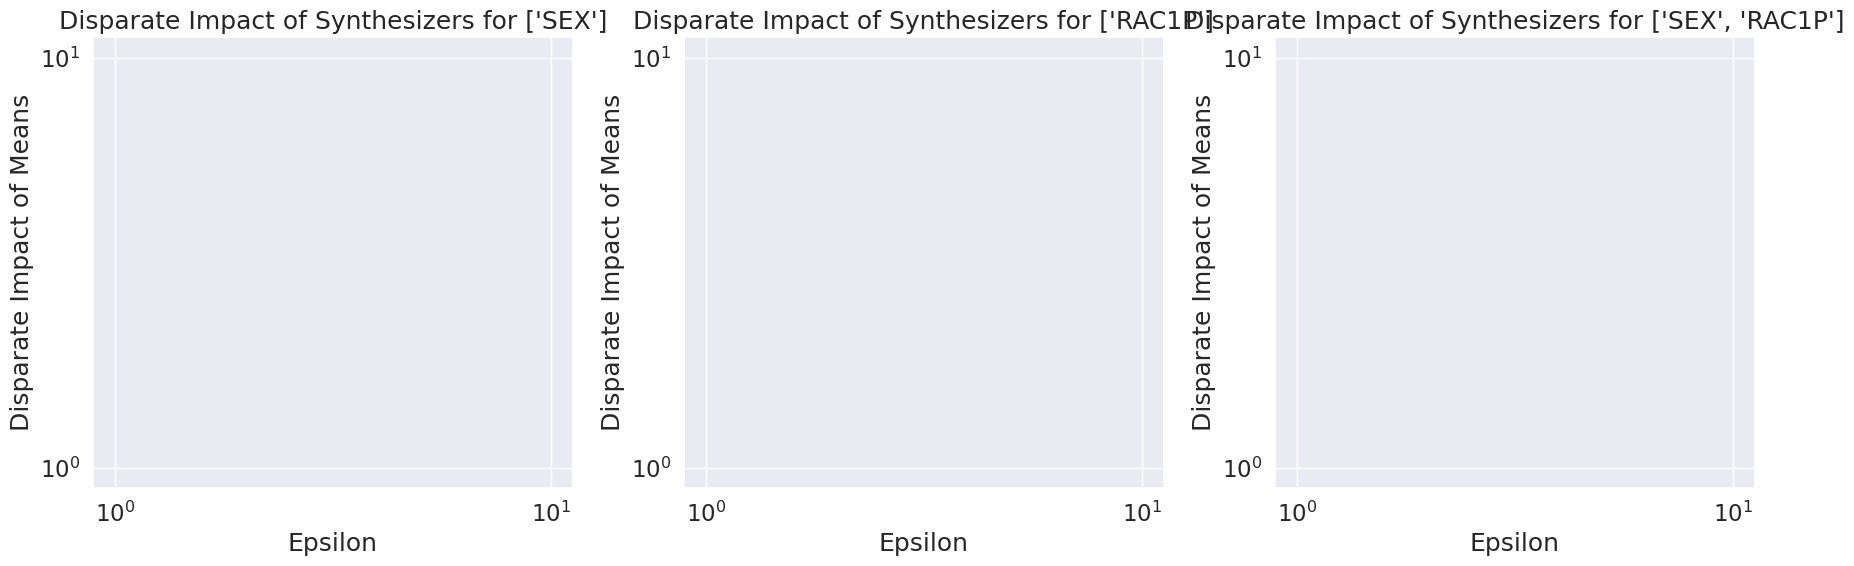

In [82]:
def plot_disparate_impact_subplots_strata_only(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['RAC1P']", "['SEX', 'RAC1P']"]
    synth_filters = {
        "['SEX']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX',
                    'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX'],
        "['RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_RAC1P',
                      'MSTSynthesizer_vanilla', 'MSTSynthesizer_RAC1P'],
        "['SEX', 'RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                             'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P'],
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        relevant_synths = synth_filters[group]
        filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]
        
        data = filtered_data[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
    
    plt.tight_layout()
    plt.show()
plot_disparate_impact_subplots_strata_only(performance_df, function_name='Means')

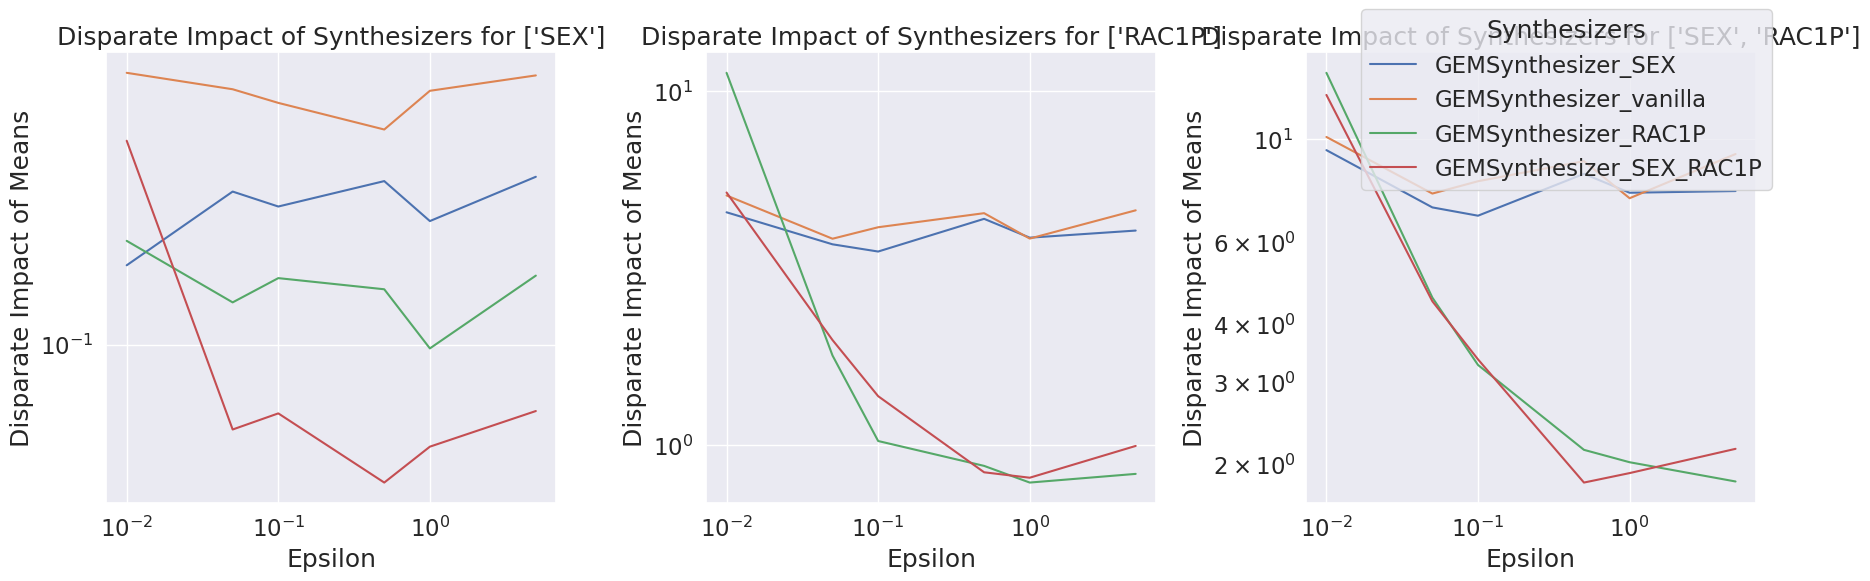

In [83]:
def plot_disparate_impact_subplots(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['RAC1P']", "['SEX', 'RAC1P']"]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        data = performance_df[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        # print(data)
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

# Call the function with your performance_df
plot_disparate_impact_subplots(performance_df, function_name='Means')
# 